Episode 100/1000, Success rate: 0.00, Avg steps: 50.00, Exploration rate: 0.1817
Episode 200/1000, Success rate: 0.04, Avg steps: 49.02, Exploration rate: 0.1101
Episode 300/1000, Success rate: 0.13, Avg steps: 47.58, Exploration rate: 0.0667
Episode 400/1000, Success rate: 0.18, Avg steps: 47.41, Exploration rate: 0.0404
Episode 500/1000, Success rate: 0.36, Avg steps: 43.35, Exploration rate: 0.0245
Episode 600/1000, Success rate: 0.39, Avg steps: 39.57, Exploration rate: 0.0148
Episode 700/1000, Success rate: 0.59, Avg steps: 34.76, Exploration rate: 0.0090
Episode 800/1000, Success rate: 0.76, Avg steps: 29.87, Exploration rate: 0.0054
Episode 900/1000, Success rate: 0.75, Avg steps: 27.86, Exploration rate: 0.0033
Episode 1000/1000, Success rate: 0.81, Avg steps: 25.56, Exploration rate: 0.0020


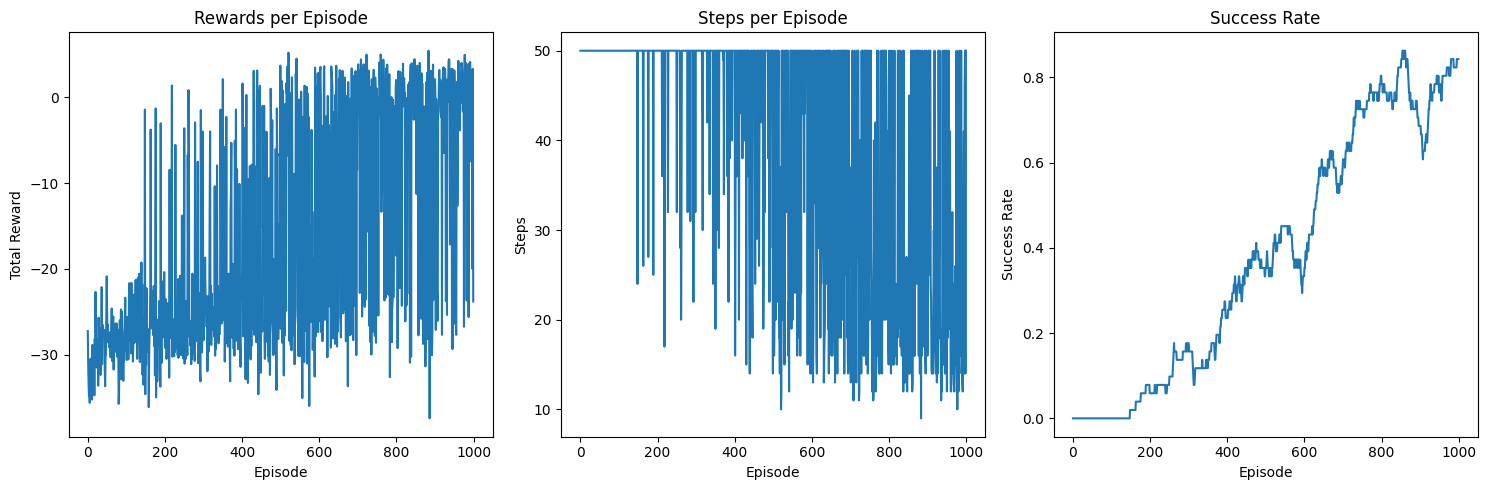

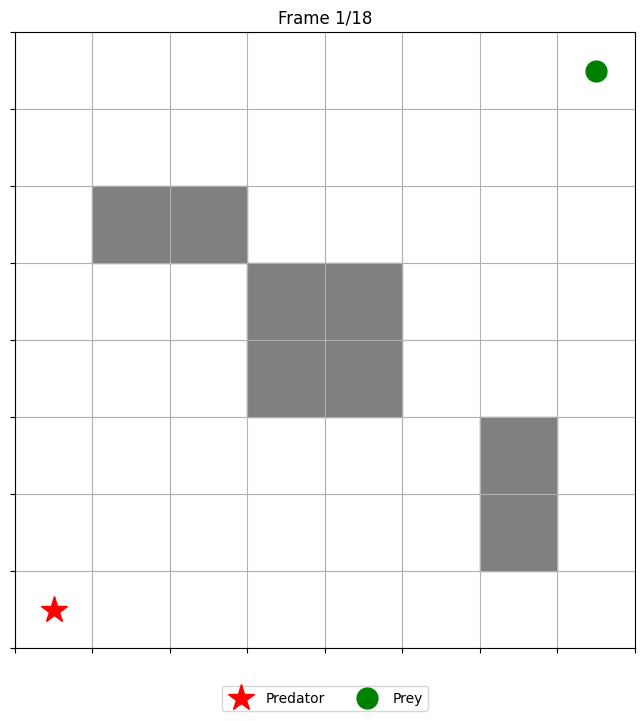

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import random

# Grid World Parameters
GRID_SIZE = 8
MAX_STEPS = 50  # Maximum steps before ending an episode

# Define agent and prey initial positions
PREDATOR_START = (0, 0)
PREY_START = (7, 7)

# Define obstacles in the environment
OBSTACLES = [(3, 3), (3, 4), (4, 3), (4, 4), (1, 6), (2, 6), (5, 1), (5, 2)]

# Possible actions: up, down, left, right
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
ACTION_NAMES = ['Up', 'Down', 'Left', 'Right']

# Q-learning parameters
LEARNING_RATE = 0.2
DISCOUNT_FACTOR = 0.9
EXPLORATION_RATE = 0.3
EPISODES = 1000
DECAY_RATE = 0.995  # Decay rate for exploration

class PredatorPreyEnv:
	def __init__(self):
		self.grid_size = GRID_SIZE
		self.obstacles = OBSTACLES
		self.reset()
		
	def reset(self):
		self.predator_pos = PREDATOR_START
		self.prey_pos = PREY_START
		self.steps = 0
		return self._get_state()
	
	def _get_state(self):
		# State is a tuple of predator and prey positions
		return (self.predator_pos, self.prey_pos)
	
	def _is_valid_move(self, pos):
		"""Check if a position is valid (within grid and not an obstacle)"""
		x, y = pos
		return (0 <= x < self.grid_size and 
					0 <= y < self.grid_size and 
					pos not in self.obstacles)
	
	def step(self, action):
		# Move predator according to action
		dx, dy = ACTIONS[action]
		new_pos = (self.predator_pos[0] + dx, self.predator_pos[1] + dy)
		
		if self._is_valid_move(new_pos):
			self.predator_pos = new_pos
		
		# Check if predator caught prey
		caught = (self.predator_pos == self.prey_pos)
		
		# Move prey randomly (but only if not caught)
		if not caught:
			self._move_prey()
		
		# Calculate reward
		if caught:
			reward = 10  # High reward for catching prey
		else:
			# Calculate Manhattan distance to prey
			dist = abs(self.predator_pos[0] - self.prey_pos[0]) + abs(self.predator_pos[1] - self.prey_pos[1])
			reward = -0.1 - (dist / (2 * self.grid_size))  # Small penalty based on distance
		
		# Increment step counter
		self.steps += 1
		
		# Check if episode is done
		done = caught or self.steps >= MAX_STEPS
		
		return self._get_state(), reward, done
	
	def _move_prey(self):
		"""Move prey randomly, but with tendency to move away from predator"""
		# Get possible moves for prey
		possible_moves = []
		
		for i, (dx, dy) in enumerate(ACTIONS):
			new_pos = (self.prey_pos[0] + dx, self.prey_pos[1] + dy)
			if self._is_valid_move(new_pos):
					# Calculate Manhattan distance from predator for this move
					dist = abs(new_pos[0] - self.predator_pos[0]) + abs(new_pos[1] - self.predator_pos[1])
					# Add the move multiple times based on distance (making it more likely to choose moves that increase distance)
					for _ in range(dist):
						possible_moves.append(new_pos)
		
		# If there are no valid moves, stay put
		if possible_moves:
			self.prey_pos = random.choice(possible_moves)

class QLearningAgent:
	def __init__(self, grid_size, n_actions):
		self.grid_size = grid_size
		self.n_actions = n_actions
		self.q_table = {}  # Dictionary to store Q values
		self.learning_rate = LEARNING_RATE
		self.discount_factor = DISCOUNT_FACTOR
		self.exploration_rate = EXPLORATION_RATE
		
	def get_action(self, state, explore=True):
		# Create key for state if not exists
		state_key = str(state)
		if state_key not in self.q_table:
			self.q_table[state_key] = np.zeros(self.n_actions)
			
		# Exploration vs exploitation
		if explore and random.random() < self.exploration_rate:
			return random.randint(0, self.n_actions - 1)  # Explore
		else:
			return np.argmax(self.q_table[state_key])  # Exploit
	
	def update(self, state, action, reward, next_state, done):
		state_key = str(state)
		next_state_key = str(next_state)
		
		# Create entry for next state if not exists
		if next_state_key not in self.q_table:
			self.q_table[next_state_key] = np.zeros(self.n_actions)
		
		# Q-learning update
		if not done:
			target = reward + self.discount_factor * np.max(self.q_table[next_state_key])
		else:
			target = reward
			
		self.q_table[state_key][action] += self.learning_rate * (target - self.q_table[state_key][action])
	
	def decay_exploration(self):
		self.exploration_rate *= DECAY_RATE

# Training function
def train(env, agent, episodes=EPISODES):
	rewards_history = []
	steps_history = []
	success_history = []
	
	for episode in range(episodes):
		state = env.reset()
		total_reward = 0
		done = False
		
		while not done:
			action = agent.get_action(state)
			next_state, reward, done = env.step(action)
			agent.update(state, action, reward, next_state, done)
			
			state = next_state
			total_reward += reward
		
		rewards_history.append(total_reward)
		steps_history.append(env.steps)
		success_history.append(1 if env.predator_pos == env.prey_pos else 0)
		
		# Decay exploration rate
		agent.decay_exploration()
		
		# Print progress every 100 episodes
		if (episode + 1) % 100 == 0:
			success_rate = sum(success_history[-100:]) / 100
			print(f"Episode {episode+1}/{episodes}, Success rate: {success_rate:.2f}, "
					f"Avg steps: {np.mean(steps_history[-100:]):.2f}, "
					f"Exploration rate: {agent.exploration_rate:.4f}")
	
	return rewards_history, steps_history, success_history

# Function to get the best trajectory after training
def get_best_trajectory(env, agent):
	trajectory = []
	state = env.reset()
	trajectory.append((env.predator_pos, env.prey_pos))
	done = False
	
	while not done and len(trajectory) < 50:  # Limit trajectory length
		action = agent.get_action(state, explore=False)  # No exploration
		next_state, reward, done = env.step(action)
		trajectory.append((env.predator_pos, env.prey_pos))
		state = next_state
		
		# Stop if we're in a loop
		if len(trajectory) > 3 and trajectory[-1] == trajectory[-3]:
			break
	
	return trajectory

# Training
env = PredatorPreyEnv()
agent = QLearningAgent(GRID_SIZE, len(ACTIONS))
rewards, steps, successes = train(env, agent)

# Plot training results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 3, 2)
plt.plot(steps)
plt.title('Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Steps')

plt.subplot(1, 3, 3)
# Calculate success rate with moving average
window_size = 50
success_rate = [np.mean(successes[max(0, i-window_size):i+1]) for i in range(len(successes))]
plt.plot(success_rate)
plt.title('Success Rate')
plt.xlabel('Episode')
plt.ylabel('Success Rate')

plt.tight_layout()
plt.show()

# Generate best trajectory for visualization
best_trajectory = get_best_trajectory(env, agent)

# Visualization
fig, ax = plt.subplots(figsize=(8, 8))

def draw_grid(frame):
	predator_pos, prey_pos = best_trajectory[frame]
	
	ax.clear()
	ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1))
	ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1))
	ax.set_xticklabels([])
	ax.set_yticklabels([])
	ax.grid(True)
	ax.set_xlim(-0.5, GRID_SIZE - 0.5)
	ax.set_ylim(-0.5, GRID_SIZE - 0.5)
	
	# Draw obstacles
	for obs in OBSTACLES:
		ax.add_patch(plt.Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1, color='gray'))
	
	# Draw predator
	ax.plot(predator_pos[1], predator_pos[0], 'r*', markersize=20, label='Predator')
	
	# Draw prey
	ax.plot(prey_pos[1], prey_pos[0], 'go', markersize=15, label='Prey')
	
	# Add legend
	ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
	
	# Add title with frame number
	ax.set_title(f'Frame {frame+1}/{len(best_trajectory)}')

anim = animation.FuncAnimation(fig, draw_grid, frames=len(best_trajectory), interval=500)
HTML(anim.to_jshtml())